### DATA EXPLORATION

##### Importing Libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import os
import re
import json
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from transformers import BertTokenizer
import torch

In [14]:
from google.colab import files
uploaded = files.upload()

Saving API_data.csv to API_data (1).csv


##### Understanding dataset characteristics

In [16]:
#Reading csv file with explicit encoding
import pandas as pd
import io

# Access the uploaded file
uploaded_file_name = 'API_data (1).csv'

# Using latin1 encoding
df = pd.read_csv(io.StringIO(uploaded[uploaded_file_name].decode('latin1')))



In [17]:
#editing columns and adding feature names
df = pd.read_csv(io.StringIO(uploaded[uploaded_file_name].decode('latin1')), names=['labels', 'text'])
pd.set_option('max_colwidth', 500)


In [18]:
df.isnull().sum()

labels    1
text      1
dtype: int64

In [19]:
df.shape

(4852, 2)

<Axes: xlabel='labels', ylabel='count'>

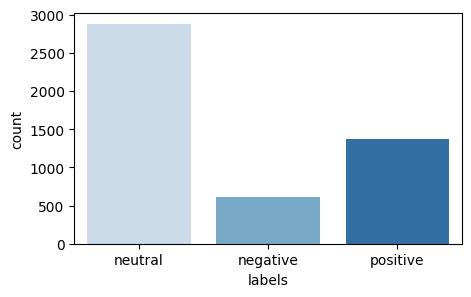

In [20]:
#checking distribution of the data
plt.figure(figsize=(5, 3))
sns.countplot(x=df.labels, palette= 'Blues')

We can see that the data is imbalanced, this could affect the predictions because the model will biased to guess towards the majority class, which in this case is 'neutral'. Therefore, we will oversample the minority classes for the model to accurately make predictions.

In [22]:
#using nltk to do name entity recognition on the text feature, and create a new feature 'name_entities' to then distinguish sentiment on then, and
#their relevance in the market

import nltk
from nltk import word_tokenize, pos_tag, ne_chunk

nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

df['text'] = df['text'].astype(str)

def extract_named_entities(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    named_entities = ne_chunk(pos_tags, binary=True)
    entities = []
    for subtree in named_entities:
        if isinstance(subtree, nltk.Tree):
            entity = " ".join([word for word, tag in subtree.leaves()])
            entities.append(entity)
    return entities

df['named_entities'] = df['text'].apply(extract_named_entities)


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [23]:
df.head()

,labels,text,named_entities
0,NaN,nan,[]
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",[Technopolis]
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .","[Elcoteq, Postimees]"
3,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,[]
4,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .",[Basware]


In [24]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
df.columns = ['labels', 'text', 'named_entities']
df = df.dropna(subset=['text', 'labels']) # droping missing values
df.head()

,labels,text,named_entities
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",[Technopolis]
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .","[Elcoteq, Postimees]"
3,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,[]
4,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .",[Basware]
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .,"[FINANCING OF ASPOCOMP, GROWTH Aspocomp, HDI, PCBs]"


In [27]:
#converting the label 'neutral', 'negative' and 'positive' classifications into encoded numerical values
label_mapping = {'neutral': 2, 'negative': 0, 'positive': 1}

# Replacing labels with numerical values
df['labels'] = df['labels'].replace(label_mapping)

<ipython-input-27-3282407bcb96>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = df['labels'].replace(label_mapping)


In [28]:
sentences = df.text.values
labels = df.labels.values

In [29]:
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, random_split, ConcatDataset
# Oversampling using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(sentences.reshape(-1, 1), labels)

# Convert back to DataFrame
df_resampled = pd.DataFrame({'text': X_resampled.flatten(), 'labels': y_resampled})

In [30]:
# Tokenize all of the resampled sentences and map the tokens to their word IDs
resampled_sentences = df_resampled.text.values
resampled_labels = df_resampled.labels.values

max_len = 0
for s in resampled_sentences:
    input_ids = tokenizer.encode(s, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('max length: ', max_len)

max length:  150


In [31]:
input_ids = []
attention_masks = []

for sent in resampled_sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        max_length=64,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
resampled_labels = torch.tensor(resampled_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
#dividin training set and testing set
from torch.utils.data import TensorDataset, random_split

# Combining the training inputs into a TensorDataset.
resampled_dataset = TensorDataset(input_ids, attention_masks, resampled_labels)

# Spliting the resampled dataset
train_size = int(0.8 * len(resampled_dataset))
val_size = len(resampled_dataset) - train_size
train_dataset, val_dataset = random_split(resampled_dataset, [train_size, val_size])

Data loader

In [33]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch
from sklearn.metrics import accuracy_score, confusion_matrix

#For fine-tuning BERT on a specific task, recommend a batch size of 16 or 32.
batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader( val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size )

Model

In [34]:
from torch.utils.data import DataLoader, SequentialSampler

batch_size = 32
validation_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=validation_sampler, batch_size=batch_size)


In [35]:
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [36]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3
  Average training loss: 0.51
  Training time: 0:01:13

Validation...
  Accuracy: 0.89
  Validation Loss: 0.29
  Validation time: 0:00:06

Epoch 2/3
  Average training loss: 0.18
  Training time: 0:01:12

Validation...
  Accuracy: 0.92
  Validation Loss: 0.24
  Validation time: 0:00:06

Epoch 3/3
  Average training loss: 0.09
  Training time: 0:01:12

Validation...
  Accuracy: 0.92
  Validation Loss: 0.26
  Validation time: 0:00:06

Total training time: 0:03:55

Mean Validation Accuracy: 0.91


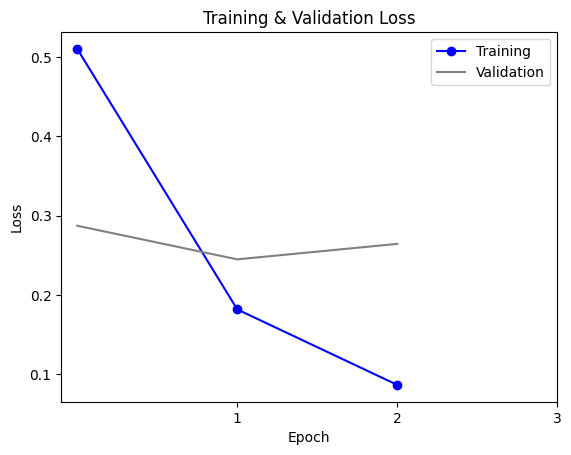

Accuracy: 0.92
Mean Squared Error: 0.11


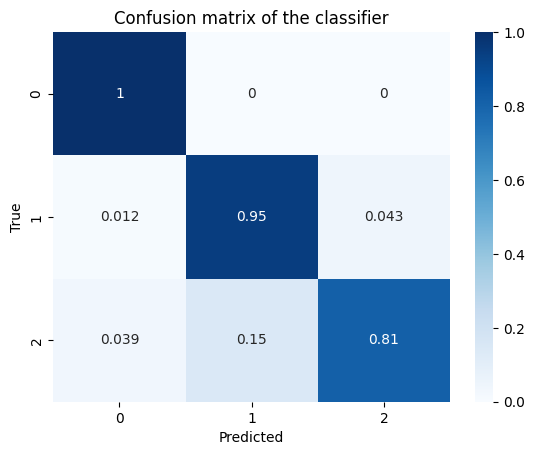

In [54]:
import torch
import time
import datetime
import numpy as np
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import pandas as pd
import matplotlib.pyplot as plt
import random

# Setting the seed value for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Loading pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False,
)

# Moving the model to the specified device
model.to(device)

# Defining the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
training_stats = []
total_t0 = time.time()

for epoch_i in range(epochs):
    print(f"\nEpoch {epoch_i + 1}/{epochs}")
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training time: {training_time}")

    # Validation
    print("\nValidation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    val_labels = []
    val_preds = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
            outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = batch[2].to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        val_labels.extend(label_ids)
        val_preds.extend(np.argmax(logits, axis=1))

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)
    validation_time = format_time(time.time() - t0)

    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation time: {validation_time}")

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Validation Loss': avg_val_loss,
        'Validation Accuracy': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time,
    })

# Total training time
print(f"\nTotal training time: {format_time(time.time()-total_t0)}")

# Displaying performance statistics
perf_df = pd.DataFrame(data=training_stats)
print(f"\nMean Validation Accuracy: {perf_df['Validation Accuracy'].mean():.2f}")

# Plotting training and validation loss
plt.plot(perf_df['Training Loss'], 'b-o', label="Training")
plt.plot(perf_df['Validation Loss'], 'gray', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1, epochs + 1))
plt.show()

# Calculating accuracy
accuracy = accuracy_score(val_labels, val_preds)
print(f"Accuracy: {accuracy:.2f}")

# Calculating mean squared error
mse = mean_squared_error(val_labels, val_preds)
print(f"Mean Squared Error: {mse:.2f}")

# Generating and plotting the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds, normalize='true')
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


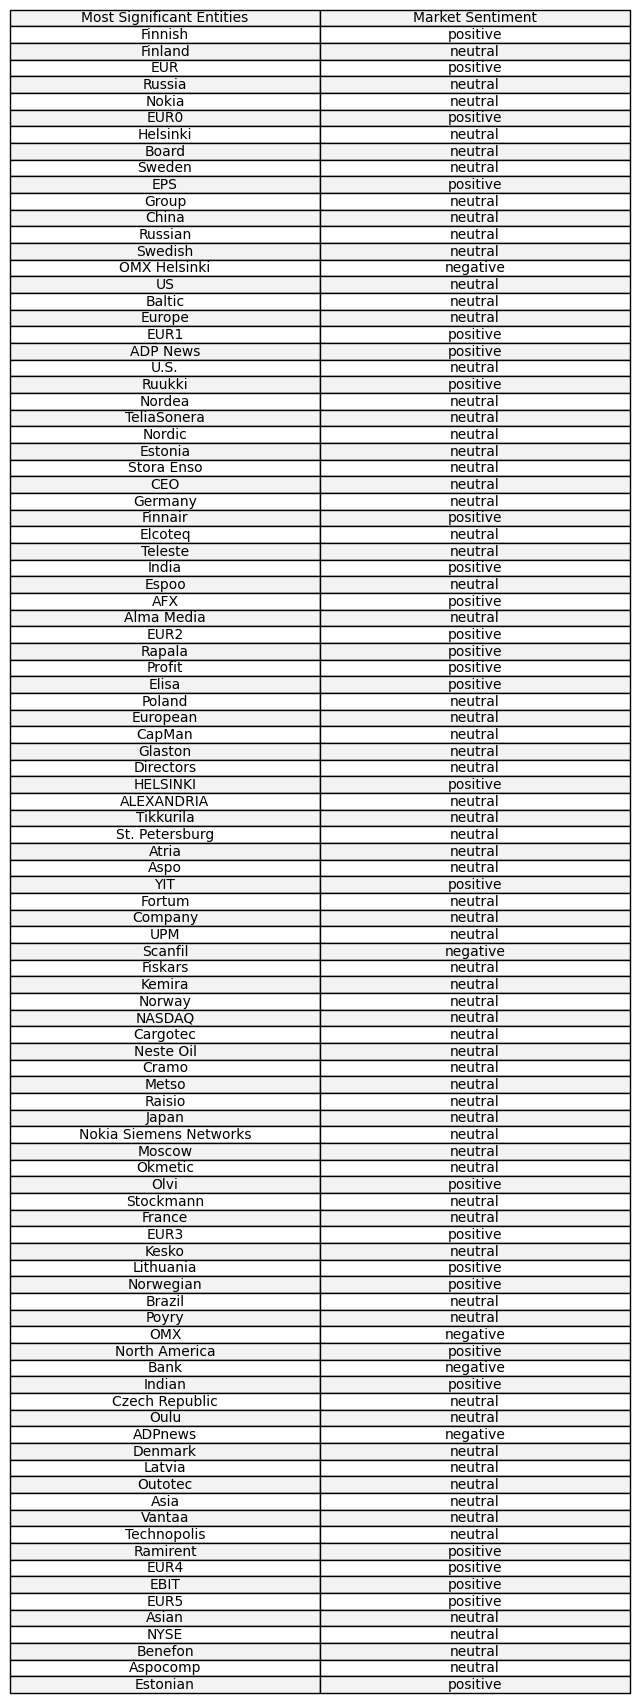

In [53]:
#taking the most talked about entities in the market, and showing their model sentiment prediction

import pandas as pd
import numpy as np
from collections import Counter


all_entities = [entity for entities_list in df['named_entities'] for entity in entities_list]
most_common_entities = [entity for entity, count in Counter(all_entities).most_common(100)]

#Looping through the most common entities and extract majority label based on BERT predictions
result_data = {'Most Significant Entities': [], 'Market Sentiment': []}

for entity in most_common_entities:
    entity_rows = df[df['named_entities'].apply(lambda entities: entity in entities)]

    # Getting BERT predictions for this entity
    entity_sentences = entity_rows['text'].values
    entity_input_ids = []
    entity_attention_masks = []

    for sent in entity_sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=64,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        entity_input_ids.append(encoded_dict['input_ids'])
        entity_attention_masks.append(encoded_dict['attention_mask'])
    entity_input_ids = torch.cat(entity_input_ids, dim=0)
    entity_attention_masks = torch.cat(entity_attention_masks, dim=0)

    entity_predictions = []
    for i in range(0, len(entity_input_ids), batch_size):
        batch_input_ids = entity_input_ids[i:i+batch_size]
        batch_attention_masks = entity_attention_masks[i:i+batch_size]
        with torch.no_grad():
            inputs = {"input_ids": batch_input_ids.to(device), "attention_mask": batch_attention_masks.to(device)}
            outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        entity_predictions.extend(np.argmax(logits, axis=1))

    majority_label = int(np.argmax(np.bincount(entity_predictions)))

    result_data['Most Significant Entities'].append(entity)
    result_data['Market Sentiment'].append(majority_label)



result_df = pd.DataFrame(result_data)
result_df['Market Sentiment'] = result_df['Market Sentiment'].map({1: 'positive', 0: 'negative', 2: 'neutral'})
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
cell_colours = [['#f3f3f3', '#ffffff'][i%2] for i in range(result_df.shape[0] + 1)]
table_data = [result_df.columns] + result_df.values.tolist()
cell_colours = [[col1, col2] for col1, col2 in zip(cell_colours, cell_colours)]
ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center', colColours=None, cellColours=cell_colours)
plt.show()